# Image recognition Project with CNN
## CAPTCHA 학습 및 break
### 전남대학교 컴퓨터정보통신공학전공 195186 김승민

## import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter
from pathlib import Path

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

img_folder = '../Lecture_NN/input/captcha-version-2-images/samples/samples/'

# Data analysis에서 label을 분석하기 위함
data_dir = Path("../Lecture_NN/input/captcha-version-2-images/samples/samples/")

## Data analysis

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'6', 'n', 'd', '4', 'e', '7', '8', '3', 'c', '5', 'y', 'b', 'f', 'x', 'g', '2', 'm', 'w', 'p'}


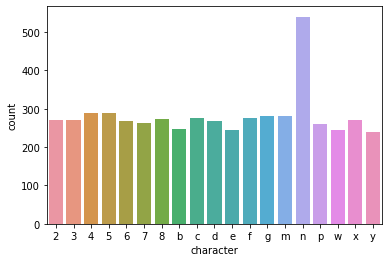

In [2]:
# Get list of all the images and labels
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

df = pd.DataFrame(columns=['filename','extension','label','labelsize','char1','char2','char3','char4','char5'])
i = 0
for _, _, files in os.walk(img_folder):
    for f in files:
        df.loc[i,'filename'] = f
        df.loc[i,'extension'] = f.split('.')[1]
        df.loc[i,'label'] = f.split('.')[0]
        df.loc[i,'labelsize'] = len(f.split('.')[0])
        df.loc[i,'char1'] = f.split('.')[0][0]
        df.loc[i,'char2'] = f.split('.')[0][1]
        df.loc[i,'char3'] = f.split('.')[0][2]
        df.loc[i,'char4'] = f.split('.')[0][3]
        df.loc[i,'char5'] = f.split('.')[0][4]
        i = i+1
        
#df.head()

data = pd.DataFrame(df['char1'].value_counts()+df['char2'].value_counts()+df['char3'].value_counts()+df['char4'].value_counts()+df['char5'].value_counts()).reset_index()
data.columns = ['character','count']

sns.barplot(data=data, x='character', y='count')
plt.show()

- CAPTCHA에서는 헷갈릴 수 있는 문자를 제외한 2,3,4,5,6,7,8 and b,c,d,e,f,g,m,n,p,w,x,y만 사용된다.
- 19개의 문자 중 5개로 구성된 CAPTCHA이다.
- 대부분의 문자 출현 빈도는 비슷하지만 n은 다른 문자들에 비해 두배정도의 출현 빈도를 지닌다.
- 데이터셋에는 같은 size를 가지는 jpg파일과 png파일이 함께 존재한다. 하지만 이 data set의 경우 jpg파일의 수가 1040개인 png파일에 비해 30개로 비교적 적기 때문에 png파일로만 학습을 진행한다.

## Evaluation Metric

In [3]:
def compute_perf_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
        return np.sum(predictions == groundtruth)/(predictions.shape[0]*predictions.shape[1])
    else:
        raise Exception('Error : the size of the arrays do not match. Cannot compute the performance metric')

모델의 정확도를 정량적으로 측정하기 위해 측정공식을 사용했다. 여기에서 사용한 Evaluation Metric는 (corrected element/5) 로 정의하여 모든 문자를 정확히 예측한 경우 1점을 부여했다

## Creation of the training and validation datasets

In [4]:
vocabulary = {'2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y'}
char_to_num = {'2':0,'3':1,'4':2,'5':3,'6':4,'7':5,'8':6,'b':7,'c':8,'d':9,'e':10,'f':11,'g':12,'m':13,'n':14,'p':15,'w':16,'x':17,'y':18}

def encode_single_sample(img_path, label, crop):
    img = tf.io.read_file(img_path)
    
    # Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1) 
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # 이미지를 crop 후 원래 이미지 사이즈로 리사이징
    if(crop==True):
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=25, target_height=50, target_width=125)
        img = tf.image.resize(img,size=[50,200],method='bilinear', preserve_aspect_ratio=False,antialias=False, name=None)

    img = tf.transpose(img, perm=[1, 0, 2])
    # Converts the string label into an array with 5 integers. E.g. '6n6gg' is converted into [6,16,6,14,14]
    label = list(map(lambda x:char_to_num[x], label))
    return img.numpy(), label

def create_train_and_validation_datasets(crop=False):
    # Loop on all the files to create X whose shape is (1040, 50, 200, 1) and y whose shape is (1040, 5)
    X, y = [],[]

    for _, _, files in os.walk(img_folder):
        for f in files:
            # jpg이미지를 무시하고 png이미지만 추출
            label = f.split('.')[0]
            extension = f.split('.')[1]
            if extension=='png':
                img, label = encode_single_sample(img_folder+f, label,crop)
                X.append(img)
                y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Split X, y to get X_train, y_train, X_val, y_val 
    X_train, X_val, y_train, y_val = train_test_split(X.reshape(1040, 10000), y, test_size=0.1, shuffle=True, random_state=42)
    X_train, X_val = X_train.reshape(936,200,50,1), X_val.reshape(104,200,50,1)
    return X_train, X_val, y_train, y_val

- 딥러닝에서의 모델 검증과 평가는 매우 중요한데 이 두가지 프로세스를 정확히 진행하기 위해선 train set과 validation set 즉 test set이 완전히 분리되어 서로의 결과에 영향을 끼치지 않는 독립적인 관계여야 한다. 만약 train set에 validation set이 섞여들어간다면 학습 단계에서 validation set을 학습하게 될 것이고, 이는 문제가 유출된 시험지를 푸는 것과 같다. 이렇게 평가된 모델은 우리가 중간고사 범위에서 매우 중요하다고 배웠던 일반화 성능이 크게 떨어지므로 모델의 일반화 성능이 왜곡되었다고 한다.
- 이 모델에서는 90%의 train set, 10%의 validation set으로 검증 및 평가를 진행한다.
- image data인 X_train은 200*50사이즈를 가진 936장의 사진으로 구성, lable data인 y_train은 5의 길이를 가진 문자열 936개로 구성된다.
- validation set에서는 image data인 X_val은 200*50사이즈를 가진 104장의 사진으로 구성, lable data인 y_val은 5의 길이를 가진 문자열 104개로 구성된다.
- 좀 더 효율적인 학습이 진행될 수 있도록 출현하는 문자들을 숫자 데이터인 0~18로 encoding하였다.

## Modeling

In [5]:
def build_model():
    
    # 이미지 삽입
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 

    # 첫번째 conv 계층
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # 두번째 conv 계층
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # layer reshape
    x = layers.Reshape(target_shape=(5, 7680), name="reshape")(x)

    # Fully Connected layers
    # dense1 layer에서는 256, dense2 layer에서는 64의 출력 발생
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dense(64, activation="relu", name="dense2")(x)
   
    # Output layer
    # activation function = softmax
    output = layers.Dense(19, activation="softmax", name="dense3")(x) 
    
    # 모델 선언
    model = keras.models.Model(inputs=input_img, outputs=output, name="CNN_classifier")
    
    # 모델 컴파일
    # optimizer = Adam, loss function = sparse_categorical_crossentropy
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")
    return model


# 모델 summary
model = build_model()
model.summary()

Model: "CNN_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 5, 7680)           0         
                                                                 
 dense1 (Dense)              (None, 5, 256)         

## Training

In [6]:
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=True)
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
30/30 [==============================] - 5s 136ms/step - loss: 2.9964 - accuracy: 0.1842 - val_loss: 2.1680 - val_accuracy: 0.3904
Epoch 2/30
30/30 [==============================] - 4s 146ms/step - loss: 1.3827 - accuracy: 0.6092 - val_loss: 0.7465 - val_accuracy: 0.8096
Epoch 3/30
30/30 [==============================] - 4s 132ms/step - loss: 0.5469 - accuracy: 0.8489 - val_loss: 0.4793 - val_accuracy: 0.8615
Epoch 4/30
30/30 [==============================] - 4s 139ms/step - loss: 0.3642 - accuracy: 0.8942 - val_loss: 0.4141 - val_accuracy: 0.8904
Epoch 5/30
30/30 [==============================] - 4s 132ms/step - loss: 0.2644 - accuracy: 0.9214 - val_loss: 0.3348 - val_accuracy: 0.9058
Epoch 6/30
30/30 [==============================] - 4s 135ms/step - loss: 0.1848 - accuracy: 0.9468 - val_loss: 0.3115 - val_accuracy: 0.9135
Epoch 7/30
30/30 [==============================] - 4s 121ms/step - loss: 0.1441 - accuracy: 0.9575 - val_loss: 0.3253 - val_accuracy: 0.9077
Epoch 

epochs를 30으로 지정하니 20번째 후반대 학습부터 최상의 성능을 얻을 수 있었고, 그 이상의 학습은 유의미하지 않았다.

## Model Performance

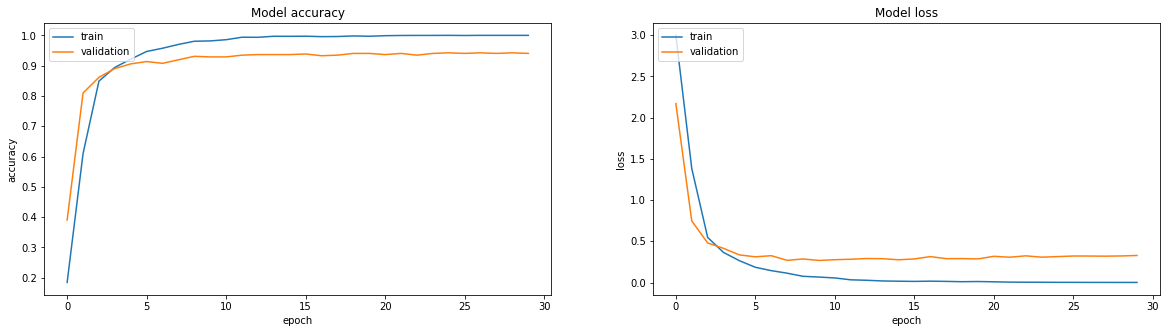

In [7]:
fig=plt.figure(figsize=(20, 5))
# accuracy
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

학습곡선이 train에 완전히 붙은 완벽한 그래프가 그려지진 않았지만 이상적인 추세를 보여준다. 이 그래프는 학습량이 부족하지도, 과하지도 않음을 나타낸다.

## Prediction

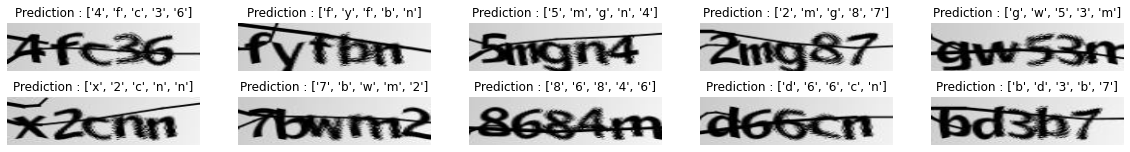

In [8]:
y_pred = model.predict(X_val) # y_pred shape = (104,50,19)
y_pred = np.argmax(y_pred, axis=2)
num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d','10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_val[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show()

validation set에서 10개의 이미지를 추출하여 Prediction값과 lable값을 비교한 결과 학습이 매우 잘 진행되었음을 확인할 수 있다.

## Model Evaluation

In [9]:
compute_perf_metric(y_pred, y_val)

0.9403846153846154

이 모델은 93%의 정확도를 보여준다.